<a href="https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/keras_sklearn_cnn1d_dna_transcription_logx.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Keras and Sklearn for Deep Learning Genomics

## Variation 1: Log Transform

This notebook is a variation on a prior notebook, `keras_sklearn_cnn1d_dna_transcription.ipynb` ([Jupyter notebook](https://github.com/charlesreid1/deep-learning-genomics/blob/master/keras_cnn1d_dna_transcription.ipynb) or [Google CoLab notebook](https://colab.research.google.com/github/charlesreid1/deep-learning-genomics/blob/master/keras_cnn1d_dna_transcription.ipynb#)). It continues with the example from a prior notebook, namely, the problem of predicting transcription factor binding sites in DNA. This type of neural network operates on 1D sequence data (DNA nucleotides), so we build a 1D convolutional neural network to perform classification of DNA (is this string of nucleotides a transcription factor binding site or not).

This notebook variation is to transform chromatin data into log space using a log transform, followed by a standard scaling transform (this ensures the log-transformed data has mean of 0 and variance of 1). The transformed data is then fed to the neural network instead of the raw chromatin coverage data. The log transform parameters are determined from the training data set and applied to the testing data set.

This notebook duplicates large sections from the `keras_sklearn_cnn1d_dna_transcription.ipynb`, so visit that notebook for details and explanations.

## Import Libraries

In [1]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [0]:
import os
import math
import numpy as np
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

In [0]:
# sklearn
from sklearn.model_selection import StratifiedKFold, StratifiedShuffleSplit

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import FunctionTransformer
from sklearn import preprocessing

from sklearn.pipeline import Pipeline

from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.metrics import confusion_matrix

from sklearn.utils import class_weight

In [4]:
from keras.models import Sequential, Model
from keras.layers import Flatten, Embedding, Dense, Dropout, Input, Concatenate
from keras.layers import Conv1D, GlobalAveragePooling1D, MaxPooling1D
import keras

Using TensorFlow backend.


In [0]:
seed = 1729
numpy.random.seed(seed)

## Define Useful Keras Metrics

In [0]:
# via https://github.com/keras-team/keras/issues/6507#issuecomment-322857357

import keras.backend as K

def precision(y_true, y_pred):
    # Calculate the precision
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def recall(y_true, y_pred):
    # Calculate the recall
    # clip ensures we're between 0 and 1
    # round ensures we're either 0 or 1
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def fvalue(y_true, y_pred):
    # Calculate the F-value
    # If there are no true positives, fix the F score at 0 like sklearn.
    if K.sum(K.round(K.clip(y_true, 0, 1))) == 0:
        return 0
    p = precision(y_true,y_pred)
    r = recall(y_true,y_pred)
    fvalue = (2 * p * r)/(p + r + K.epsilon())
    return fvalue


## Load Dataset

In [7]:
!git clone https://github.com/deepchem/DeepLearningLifeSciences.git

fatal: destination path 'DeepLearningLifeSciences' already exists and is not an empty directory.


In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/{test*,train*,valid*} .

In [0]:
!ln -fs DeepLearningLifeSciences/Chapter06/chromatin.txt

In [10]:
def load_all_data():
    
    # load chromatin accessibility data
    accessibility = {}
    for line in open('chromatin.txt','r'):
        fields = line.split()
        accessibility[fields[0]] = float(fields[1])
    
    # load training, validation, and testing sets
    for i,label in enumerate(['train','valid','test']):
        datadir = "%s_dataset"%(label)
        base_filename = "shard-0-%s.joblib"
        X_filename = os.path.join(datadir,base_filename%("X"))
        y_filename = os.path.join(datadir,base_filename%("y"))
        w_filename = os.path.join(datadir,base_filename%("w"))
        ids_filename = os.path.join(datadir,base_filename%("ids"))
        
        this_X = joblib.load(X_filename)
        this_y = joblib.load(y_filename)
        this_w = joblib.load(w_filename)
        this_ids = joblib.load(ids_filename)
        this_chromatin = np.array([accessibility[k] for k in this_ids])
        
        # add X and chromatin data
        if i>0:
            X = np.concatenate([X,this_X])
            chromatin = np.concatenate([chromatin,this_chromatin])
            y = np.concatenate([y,this_y])
            w = np.concatenate([w,this_w])
            ids = np.concatenate([ids,this_ids])
        else:
            X = this_X
            chromatin = this_chromatin
            y = this_y
            w = this_w
            ids = this_ids
    
    # Don't transform chromatin data here!!!
    # wait until we have our training/testing split
    # (otherwise we will introduce bias)
    
    return [X,chromatin], y, w, ids

[X,chromatin], y, w, ids = load_all_data()

print("Shape of all data:\n")

print("X shape:")
print(np.shape(X))

print("chromatin shape:")
print(np.shape(chromatin))

print("y shape:")
print(np.shape(y))

print("w shape:")
print(np.shape(w))

Shape of all data:

X shape:
(345271, 101, 4)
chromatin shape:
(345271,)
y shape:
(345271, 1)
w shape:
(345271, 1)


In [11]:
print(np.min(chromatin))
print(np.max(chromatin))
print(np.mean(chromatin))

0.0
0.166999
0.0039958571122393725


## Get Class Weights for Training

In [12]:
classes = np.unique(y)
labels = np.squeeze(y)

weights = class_weight.compute_class_weight('balanced',classes,labels)

class_weights = {}
for c,w in zip(classes,weights):
    class_weights[c] = w
print(class_weights)

{0: 0.5021232595815724, 1: 118.24349315068493}


## Stratified K-Fold Validation

In [0]:
def create_chromatin():
    """Create and return a 1D convolutional neural net model.
    This model incorporates chromatin accessibility data.
    """
    # DNA sequence alphabet size
    n_features = 4
    seq_length = 101
    convolution_window = 10
    n_filters = 16
    
    # ----------------------------
    # Sequence branch of network
    # (1D DNA sequence)
    
    # Input
    seq_in = Input(shape=(seq_length,n_features))
    
    # Fencepost pattern
    seq = seq_in
    
    # 3 convolutional layers
    for i in range(3):
        seq = Conv1D(n_filters, convolution_window,
                    activation='relu',
                     padding='same',
                     kernel_initializer='normal')(seq)
        seq = Dropout(0.5)(seq)
    
    # Flatten to 1D
    seq = Flatten()(seq)
    
    # Assemble the sequential branch of network
    seq = keras.Model(inputs=seq_in, outputs=seq)
    
    # ---------------------------
    # Chromatin branch of network
    
    # Input
    chrom_input = Input(shape=(1,))
    
    # ---------------------------
    # Combine networks
    fin = keras.layers.concatenate([seq.output, chrom_input])
    fin = Dense(1,
                kernel_initializer='normal',
                activation='sigmoid')(fin)
    chrom_model = keras.Model(inputs=[seq.input,chrom_input], outputs=fin)
    
    # Compile model
    chrom_model.compile(loss='binary_crossentropy',
                       optimizer='adam',
                       sample_weight_mode=None,
                       metrics=['accuracy',
                               precision,
                               recall,
                               fvalue])
    
    return chrom_model

## Performing Cross Validation Manually (Transformed Data)

Next we perform cross-validation, incorporating class weights as in the example at the end of `keras_sklearn_cnn1d_dna_transcription.ipynb`.

We use a [StratifiedShuffleSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.StratifiedShuffleSplit.html#sklearn.model_selection.StratifiedShuffleSplit) object again to create our test/train splits.

In [0]:
n_fold = 3

# we can use either of these,
# but we'll opt for shuffle

kfold = StratifiedKFold(n_splits=n_fold, 
                        shuffle=True, 
                        random_state=seed)

shuffle = StratifiedShuffleSplit(n_splits=n_fold,
                                 train_size = 0.7,
                                 test_size = 0.3,
                                 random_state = seed)

### Visualizing the Log Transform

Let's first examine what the log transform will do to this data set:

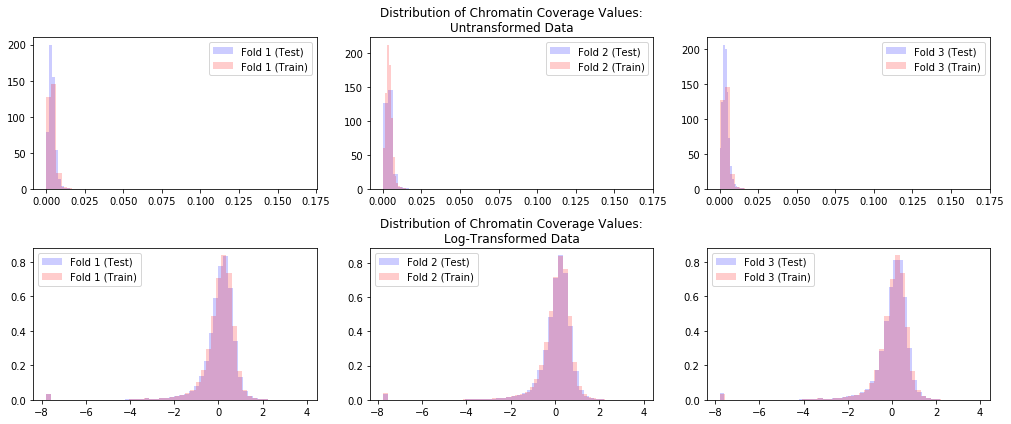

In [15]:
fig, axes = plt.subplots(2,3,figsize=(14,6))

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = np.squeeze(chromatin[train_ix]), np.squeeze(chromatin[test_ix])
    
    lab_test = 'Fold %d (Test)'%(ifold+1)
    lab_train = 'Fold %d (Train)'%(ifold+1)
    
    # Row 0 is the untransformed data:
    
    sns.distplot(chrom_test, ax=axes[0,ifold], 
                 label=lab_test,
                 kde=False, 
                 norm_hist=True, 
                 hist_kws={'alpha':0.2,"color": "b"})

    sns.distplot(chrom_train, ax=axes[0,ifold], 
                 label=lab_train,
                 kde=False, 
                 norm_hist=True, 
                 hist_kws={'alpha':0.2,"color": "r"})
    
    ########################################
    # Perform log transform
    logfunc = lambda x : np.log(x+1e-6)
    logx = FunctionTransformer(logfunc, validate=True)
    stdx = StandardScaler()
    pipe = Pipeline([('logx',logx),('stdx',stdx)])
    chromx_train = pipe.fit_transform(chrom_train.reshape(-1,1))
    chromx_test = pipe.transform(chrom_test.reshape(-1,1))
    ########################################

    # Row 1 is the transformed data:
    
    sns.distplot(chromx_test, ax=axes[1,ifold], 
                 label=lab_test,
                 kde=False, 
                 norm_hist=True, 
                 hist_kws={'alpha':0.2,"color": "b"})

    sns.distplot(chromx_train, ax=axes[1,ifold], 
                 label=lab_train,
                 kde=False, 
                 norm_hist=True, 
                 hist_kws={'alpha':0.2,"color": "r"})

    axes[0,ifold].legend()
    axes[1,ifold].legend()

axes[0,1].set_title('Distribution of Chromatin Coverage Values:\nUntransformed Data')
axes[1,1].set_title('Distribution of Chromatin Coverage Values:\nLog-Transformed Data')
plt.tight_layout()
plt.show()

In [16]:
n_epochs = 50
batch_size = 2048
include_chromatin_data = True

transformers = []
models = []
fithists = []

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = np.squeeze(chromatin[train_ix]), np.squeeze(chromatin[test_ix])
    
    ########################################
    # Perform log transform
    logfunc = lambda x : np.log(x+1e-6)
    logx = FunctionTransformer(logfunc, validate=True)
    stdx = StandardScaler()
    pipe = Pipeline([('logx',logx),('stdx',stdx)])
    chromx_train = pipe.fit_transform(chrom_train.reshape(-1,1))
    chromx_test = pipe.transform(chrom_test.reshape(-1,1))
    ########################################
    
    print("Training on fold %d..."%(ifold+1))
    
    # if we use the chromatin model, 
    # we need to provide the network
    # with a *list* of inputs
    
    if include_chromatin_data:
        model = create_chromatin()
        hist = model.fit([X_train,chromx_train], y_train,
                         class_weight = class_weights,
                         batch_size = batch_size,
                         epochs = n_epochs,
                         verbose = 0,
                         validation_data=([X_test,chromx_test],y_test))
    else:
        model = create_baseline()
        hist = model.fit(X_train, y_train,
                         class_weight = class_weights,
                         batch_size = batch_size,
                         epochs = n_epochs,
                         verbose = 0,
                         validation_data=(X_test,y_test))

    transformers.append(pipe)
    models.append(model)
    fithists.append(hist)
    
    print("Done")

Training on fold 1...
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
Done
Training on fold 2...
Done
Training on fold 3...
Done


In [17]:
print("Model results (validation):")
print("\n")
print("Loss (Mean):      %0.4f"%(np.mean([h.history['val_loss'] for h in fithists])))
print("Loss (Std):       %0.4f"%(np.std([h.history['val_loss'] for h in fithists])))
print("\n")
print("Accuracy (Mean):  %0.2f%%"%(100*np.mean([h.history['val_acc'] for h in fithists])))
print("Accuracy (Std):   %0.2f%%"%(100*np.std([h.history['val_acc'] for h in fithists])))
print("\n")
print("Precision (Mean): %0.2f%%"%(100*np.mean([h.history['val_precision'] for h in fithists])))
print("Precision (Std):  %0.2f%%"%(100*np.std([h.history['val_precision'] for h in fithists])))
print("\n")
print("Recall (Mean):    %0.2f%%"%(100*np.mean([h.history['val_recall'] for h in fithists])))
print("Recall (Std):     %0.2f%%"%(100*np.std([h.history['val_recall'] for h in fithists])))

Model results (validation):


Loss (Mean):      0.6844
Loss (Std):       0.0660


Accuracy (Mean):  57.25%
Accuracy (Std):   6.99%


Precision (Mean): 0.82%
Precision (Std):  0.13%


Recall (Mean):    81.31%
Recall (Std):     5.06%


In [0]:
def loss_rate_plot(hist, ax, label='',legend=False):
    ax.plot(hist.history['loss'])
    ax.plot(hist.history['val_loss'])
    if label=='':
        ax.set_title("Loss Rate", size=14)
    else:
        ax.set_title("Loss Rate (%s)"%(label), size=14)
    ax.set_ylabel('Loss')
    ax.set_xlabel('Training interations')
    if legend:
        ax.legend(['Training', 'Validation'], loc='upper right')

def accuracy_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['acc']])
    ax.plot([j*100 for j in hist.history['val_acc']])
    if label=='':
        ax.set_title("Accuracy", size=14)
    else:
        ax.set_title("Accuracy (%s)"%(label), size=14)
    ax.set_ylabel('Accuracy %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def precision_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['precision']])
    ax.plot([j*100 for j in hist.history['val_precision']])
    if label=='':
        ax.set_title("Precision", size=14)
    else:
        ax.set_title("Precision (%s)"%(label), size=14)
    ax.set_ylabel('Precision %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

def recall_rate_plot(hist,ax,label='',legend=False):
    ax.plot([j*100 for j in hist.history['recall']])
    ax.plot([j*100 for j in hist.history['val_recall']])
    if label=='':
        ax.set_title("Recall", size=14)
    else:
        ax.set_title("Recall (%s)"%(label), size=14)
    ax.set_ylabel('Recall %')
    ax.set_xlabel('Training iterations')
    if legend:
        ax.legend(['Training','Validation'], loc='lower right')

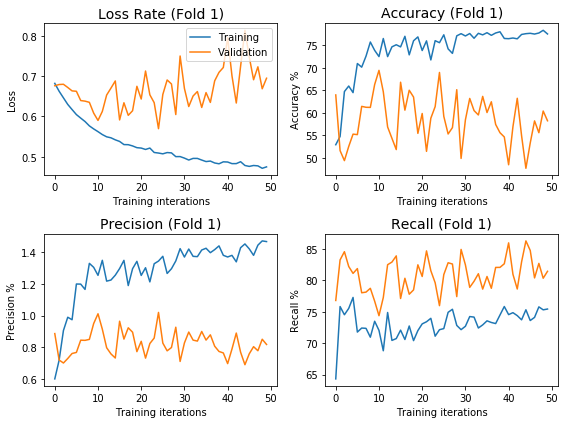

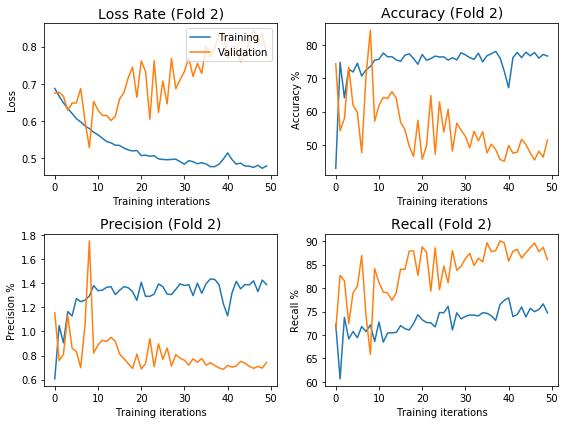

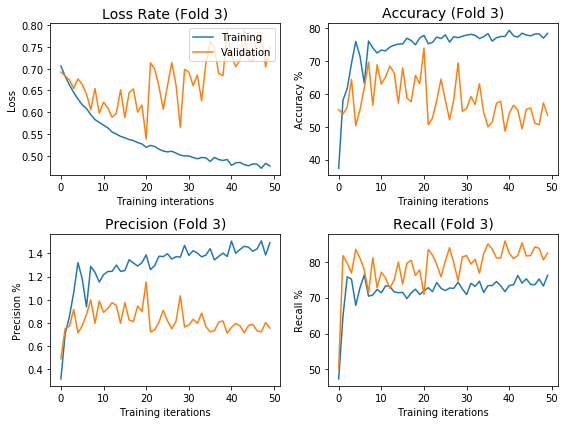

In [19]:
for i in range(shuffle.get_n_splits()):
    
    fig, [[ax1,ax2],[ax3,ax4]] = plt.subplots(2,2, figsize=(8,6))

    loss_rate_plot(fithists[i],      ax1, legend=True, label="Fold %d"%(i+1))
    accuracy_rate_plot(fithists[i],  ax2, label="Fold %d"%(i+1))
    precision_rate_plot(fithists[i], ax3, label="Fold %d"%(i+1))
    recall_rate_plot(fithists[i],    ax4, label="Fold %d"%(i+1))

    fig.tight_layout()
    
plt.show()

In [0]:
def plot_confusion_matrix(y_true, y_pred, classes,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    """
    if not title:
        title = 'Confusion matrix'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    print('Confusion matrix:')
    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = ','
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

---------------
Confusion Matrix - Fold 1:
Confusion matrix:
[[59946 43198]
 [   82   356]]
---------------
Confusion Matrix - Fold 2:
Confusion matrix:
[[52942 50202]
 [   63   375]]
---------------
Confusion Matrix - Fold 3:
Confusion matrix:
[[55047 48097]
 [   72   366]]


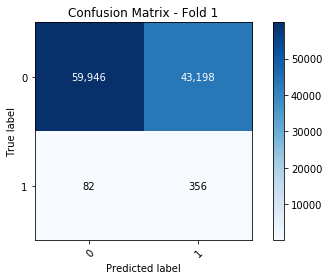

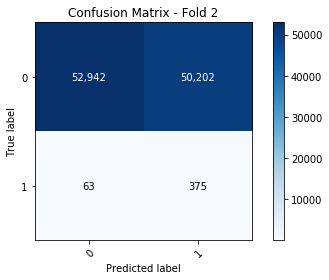

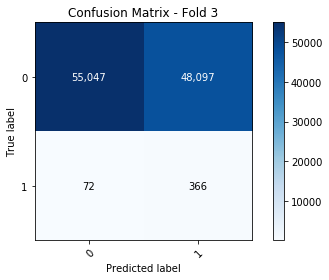

In [21]:
for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("---------------")
    print("Confusion Matrix - Fold %d:"%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    transformer = transformers[ifold]
    
    ##########################
    # apply power transformer
    chromx_train = transformer.transform(chrom_train.reshape(-1,1))
    chromx_test  = transformer.transform(chrom_test.reshape(-1,1))
    ##########################
    
    model = models[ifold]
    
    if include_chromatin_data:
        y_test_pred = model.predict([X_test,chromx_test])
    else:
        y_test_pred = model.predict(X_test)
        
    y_test_pred = np.round(y_test_pred)

    ax = plot_confusion_matrix(y_test, y_test_pred, ['0','1'], title="Confusion Matrix - Fold %d"%(ifold+1))


Finally, we compute the ROC curve for all k models from the k-fold cross-validation and use those curves to assemble the mean and variance of the ROC curve at every point by assuming the samples come from a normal distribution (equivalent to assuming the error in the model is normally distributed). See [ROC with cross validation example](https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html) in the sklearn documentation.

In [0]:
def plot_roc_curve(y_true, y_pred, weights):
    fpr, tpr, _ = roc_curve(y_true, y_pred)#, 
                            #sample_weight = weights)
    
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc_score(y_true, y_pred))
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.plot([0,1],[0,1],'k--')
    ax.set_title("ROC Curve")
    plt.legend(loc='lower right')
    plt.show()
    
    fig.tight_layout()
    return ax

Working on fold 1...
Working on fold 2...
Working on fold 3...
Area under curve:
Mean: 0.6038
Std: 0.0087


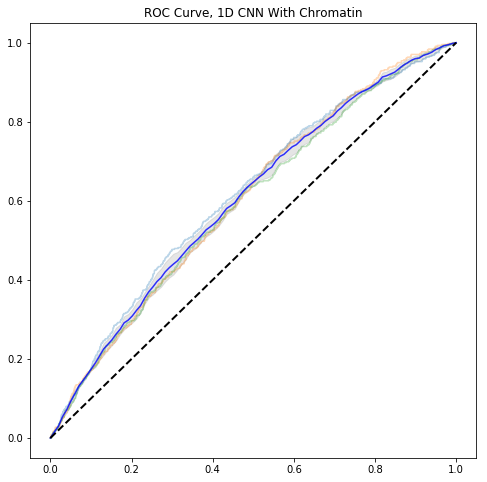

In [23]:
# https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

from scipy import interp

fig, ax = plt.subplots(1,1,figsize=(8,8))

tprs = []
aucs = []
mean_fpr = np.linspace(0,1,100)

for ifold, (train_ix, test_ix) in enumerate(shuffle.split(X,y)):

    print("Working on fold %d..."%(ifold+1))
    
    X_train, X_test = X[train_ix], X[test_ix]
    y_train, y_test = y[train_ix], y[test_ix]
    chrom_train, chrom_test = chromatin[train_ix], chromatin[test_ix]
    
    model = models[ifold]
    
    if include_chromatin_data:
        y_test_pred = model.predict([X_test,chrom_test]).ravel()
    else:
        y_test_pred = model.predict(X_test).ravel()
        
    fpr, tpr, thresholds = roc_curve(y_test, y_test_pred)
    tprs.append(interp(mean_fpr,fpr,tpr))
    tprs[-1][0] = 0.0
    roc_auc = auc(fpr,tpr)
    aucs.append(roc_auc)
    ax.plot(fpr,tpr, alpha=0.3)


mean_tpr = np.mean(tprs,axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b', alpha=0.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=0.2)

ax.plot([0,1],[0,1],'--k',lw=2)

ax.set_title('ROC Curve, 1D CNN With Chromatin')

print("Area under curve:")
print("Mean: %0.4f"%(mean_auc))
print("Std: %0.4f"%(std_auc))

plt.show()